In [1]:
#search for import above the current directory
import sys
import os
from pathlib import Path
cwd = Path().resolve().parent

sys.path.insert(1, os.path.join(cwd, 'Isotomics'))

import numpy as np
import pandas as pd
from tqdm import tqdm
import json
import copy
import matplotlib.pyplot as plt

import basicDeltaOperations as op

In [2]:
def multipleEnrichmentToSingle(multipleEnrichmentDelta, deltaErr, nSubs):
	alpha = multipleEnrichmentDelta/1000 + 1
	predictedSingle = np.power(alpha,1/nSubs)
	singleDelta = 1000*(predictedSingle-1)
	
	err = 1/nSubs * deltaErr

	return singleDelta, err

def getAliphaticEnrich(aromaticDelta, fragDelta, aromaticDeltaErr = 0, fragDeltaError = 0, fixedCont = False):
	aliphaticDeltas = []
	totalDeltas = []
	for i in range(1000):
		aliphaticCont = np.random.uniform(0,1)
		nAliphatic = 2 + aliphaticCont
		nAromatic = 2 - aliphaticCont

		if fixedCont:
			nAliphatic = 2
			nAromatic = 2

		aromaticEnrich = np.random.normal(aromaticDelta, aromaticDeltaErr)
		fragEnrich = np.random.normal(fragDelta, fragDeltaError)

		aliphaticEnrich = 1/nAliphatic * (fragEnrich * (nAliphatic + nAromatic) - nAromatic * aromaticEnrich)

		totalEnrich = (3 * aliphaticEnrich + 2 * aromaticEnrich) / 5

		aliphaticDeltas.append(aliphaticEnrich)
		totalDeltas.append(totalEnrich)

	aliphaticDeltas = np.array(aliphaticDeltas)
	totalDeltas = np.array(totalDeltas)

	print(f'Aliphatic Enrichment {aliphaticDeltas.mean():.2f} +/- {aliphaticDeltas.std():.2f}')
	print(f'Total Enrichment {totalDeltas.mean():.2f} +/- {totalDeltas.std():.2f}')

	return np.array(aliphaticDeltas), np.array(totalDeltas)

In [4]:
with open('235_data.json', 'r') as f:
    frag_235 = json.load(f)

with open('316_data.json', 'r') as f:
    frag_316 = json.load(f)

with open('20241027_235_17_results.json') as f:
    deep_results = json.load(f)
frag_235['20241027_235_17'] = deep_results['20241027_235_17']

In [5]:
# Initialize base data structure
data = {
    'AGI': {'235': {}, '316': {}, 'EA-IRMS': {'13C': {'Value': -26.2, 'Error': 0.1}}},
    'LGC': {'235': {}, '316': {}, 'EA-IRMS': {'13C': {'Value': -26.8, 'Error': 0.1}}},
    'ZeroEnrichment': {'235':{}, '316': {}, 'EA-IRMS': {'13C': {"Value": -28.0, 'Error':0}}},
    'WP':  {'235': {}, '316': {}},
    'SPB': {'235': {}, '316': {}}
}

# Mapping from long keys to short isotopologue keys
keymap = {
    '13C/Unsub': '13C',
    '37Cl/Unsub': '37Cl',
    '37Cl-13C/Unsub': '37Cl13C',
    '37Cl-37Cl/Unsub': '37Cl37Cl',
    '37Cl-37Cl-13C/Unsub': '37Cl37Cl13C',
    '37Cl-37Cl-37Cl/Unsub': '37Cl37Cl37Cl'
}

these_fragments = [frag_235, frag_316]
# Process each entry in loaded
for this_frag in these_fragments:
    for key, result in this_frag.items():
        parts = key.split('_')  # e.g., ['20240801', '235', 'LGC']
        _, sample, lab = parts

        # Remap lab name if needed
        if lab == '40':
            lab = 'WP'

        if lab == '17':
            lab = 'SPB'

        target = data[lab][sample]

        for longkey, shortkey in keymap.items():
            if longkey not in result:
                continue
            entry = result[longkey]
            mean_delta = entry['Mean Delta']
            if lab not in ['WP','17']:
                meth_repro = entry['Mean Experimental Reproducibility']
            else:
                meth_repro = entry['Experimental Reproducibility']
            mean_acq_error = np.mean(entry['Propagated Acquisition Errors']) / np.sqrt(len(entry['Propagated Acquisition Errors']))

            target[shortkey] = {
                'Value': round(mean_delta, 2),
                'ER': round(meth_repro, 2),
                'prop_AE': round(mean_acq_error, 2),
                'Error': max(round(mean_acq_error, 2), round(meth_repro, 2)),
                #'Error':np.sqrt(mean_acq_error**2 + exp_repro**2)
                #'Error': round(mean_acq_error, 2)
            }

# Output final filled data
print(json.dumps(data, indent=2))

{
  "AGI": {
    "235": {
      "13C": {
        "Value": 1.94,
        "ER": 0.11,
        "prop_AE": 0.13,
        "Error": 0.13
      },
      "37Cl": {
        "Value": 1.21,
        "ER": 0.06,
        "prop_AE": 0.07,
        "Error": 0.07
      },
      "37Cl13C": {
        "Value": 3.01,
        "ER": 0.19,
        "prop_AE": 0.15,
        "Error": 0.19
      },
      "37Cl37Cl": {
        "Value": 2.43,
        "ER": 0.19,
        "prop_AE": 0.15,
        "Error": 0.19
      },
      "37Cl37Cl13C": {
        "Value": 4.63,
        "ER": 0.22,
        "prop_AE": 0.38,
        "Error": 0.38
      }
    },
    "316": {
      "37Cl": {
        "Value": 0.59,
        "ER": 0.16,
        "prop_AE": 0.21,
        "Error": 0.21
      },
      "37Cl37Cl": {
        "Value": 1.61,
        "ER": 0.21,
        "prop_AE": 0.25,
        "Error": 0.25
      },
      "37Cl37Cl37Cl": {
        "Value": 3.37,
        "ER": 0.52,
        "prop_AE": 0.44,
        "Error": 0.52
      }
    },
    

In [18]:
#change this key to generate the additional plots. The ylimits for each can be set manually.
smp = 'LGC'

#AGI
#textPositions = [4.0] * 4
ylims = (0,5.2)

#LGC
#textPositions = [3.0] * 4
ylims = (-1.7,4)

#ZeroEnrichment
#ylims = (-1.5,3.0)

EA
1.2345679012346622
0.14142135623730953
-0.06 +/- 0.13
-0.20 +/- 0.17
316 Cl WAV
-0.06 +/- 0.09
Aliphatic Enrichment -0.50 +/- 0.20
Total Enrichment -0.04 +/- 0.12
PREDICTIONS: 316
37Cl37Cl
0.28
0.42
37CL37Cl37Cl
0.42
0.63
PREDICTIONS 235
37Cl37Cl
1.30
0.14
13C37Cl
2.12
0.15
13C37Cl37Cl
2.77
0.19


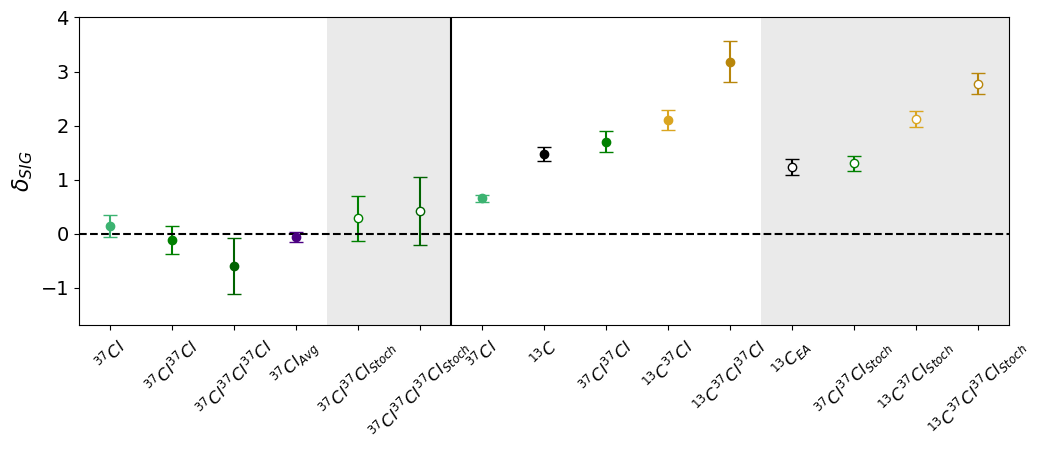

In [19]:
import matplotlib.pyplot as plt

plt.rcParams['ytick.labelsize'] = 14

###1: UNPACK DICTIONARY
#316 Frag
Cl = data[smp]['316']['37Cl']['Value']
ClErr = data[smp]['316']['37Cl']['Error']
ClDoub = data[smp]['316']['37Cl37Cl']['Value']
ClDoubErr = data[smp]['316']['37Cl37Cl']['Error']
ClTrip = data[smp]['316']['37Cl37Cl37Cl']['Value'] 
ClTripErr = data[smp]['316']['37Cl37Cl37Cl']['Error'] 
#235 Frag
aromaticDelta = data[smp]['235']['37Cl']['Value']
aromaticDeltaErr = data[smp]['235']['37Cl']['Error']
single13 = data[smp]['235']['13C']['Value']
single13Err = data[smp]['235']['13C']['Error']
C13Cl = data[smp]['235']['37Cl13C']['Value']
C13ClErr = data[smp]['235']['37Cl13C']['Error']
ClCl = data[smp]['235']['37Cl37Cl']['Value']
ClClErr = data[smp]['235']['37Cl37Cl']['Error']
C13ClCl = data[smp]['235']['37Cl37Cl13C']['Value']
C13ClClErr = data[smp]['235']['37Cl37Cl13C']['Error']
#EA Data
C13EAPDB = data[smp]['EA-IRMS']['13C']['Value']
C13EAErrPDB = data[smp]['EA-IRMS']['13C']['Value']

#Convert from VPDB reference frame to vs SIG standard (-28.0 +/- 0.1)
C13EA = 1000*(op.deltaToRatio('13C', C13EAPDB) / op.deltaToRatio('13C', -28.0) - 1)
C13EAErr = np.sqrt(2) * 0.1
print("EA")
print(C13EA)
print(C13EAErr)

###2: Get estimates for single 37Cl in 316 fragment based on 3737 and 373737. Get weighted average. ###
###
###
#Compute single 37Cl enrichment for the 316 fragment data 
ClviaDoub, ClviaDoubErr = multipleEnrichmentToSingle(ClDoub, ClDoubErr, 2)
ClviaTrip, ClviaTripErr = multipleEnrichmentToSingle(ClTrip, ClTripErr, 3)

print(f'{ClviaDoub:.2f} +/- {ClviaDoubErr:.2f}')
print(f'{ClviaTrip:.2f} +/- {ClviaTripErr:.2f}')

#Get weighted errors 
wCl = 1/ClErr**2
wClDoub = 1/ClviaDoubErr**2
wClTrip = 1/ClviaTripErr**2

weights = [wCl, wClDoub, wClTrip]
values = [Cl, ClviaDoub, ClviaTrip]

#Calculate the weighted 37Cl value for the 316 fragment based on multiple observations 
Clwav = np.dot(weights, values) / np.sum(weights)
ClwavErr = np.sqrt(1 / np.sum(weights))

print("316 Cl WAV")
print(f'{Clwav:.2f} +/- {ClwavErr:.2f}')

###Also compute estimates for aliphatic deltas and total deltas (37Cl)
aliDelta, totDelta = getAliphaticEnrich(aromaticDelta=aromaticDelta, fragDelta=Clwav, aromaticDeltaErr = aromaticDeltaErr, fragDeltaError = ClwavErr, fixedCont=False)

###3 get predicted values for various clumps based on the individual subs
###
###
def deltaToAlpha(x):
    return x/1000+1
def alphaToDelta(x):
    return 1000*(x-1)

ClClPred = alphaToDelta(deltaToAlpha(aromaticDelta)**2)
ClClPredErr = 2 * aromaticDeltaErr
C13ClPred = alphaToDelta(deltaToAlpha(aromaticDelta) * deltaToAlpha(single13))
C13ClPredErr = np.sqrt(aromaticDeltaErr**2 + single13Err**2)
C13ClClPred = alphaToDelta(deltaToAlpha(aromaticDelta)**2 * deltaToAlpha(single13))
#get error on ClCl with 2*aromaticDeltaErr PRIOR to adding
C13ClClPredErr = np.sqrt((2*aromaticDeltaErr)**2 + single13Err**2)

ClDoubPred = alphaToDelta(deltaToAlpha(Cl)**2)
ClDoubPredErr = 2 * ClErr
ClTripPred = alphaToDelta(deltaToAlpha(Cl)**3)
ClTripPredErr = 3 * ClErr

print("PREDICTIONS: 316")
print("37Cl37Cl")
print(f'{ClDoubPred:.2f}')
print(f'{ClDoubPredErr:.2f}')
print("37CL37Cl37Cl")
print(f'{ClTripPred:.2f}')
print(f'{ClTripPredErr:.2f}')

print("PREDICTIONS 235")
print("37Cl37Cl")
print(f'{ClClPred:.2f}')
print(f'{ClClPredErr:.2f}')
print("13C37Cl")
print(f'{C13ClPred:.2f}')
print(f'{C13ClPredErr:.2f}')
print("13C37Cl37Cl")
print(f'{C13ClClPred:.2f}')
print(f'{C13ClClPredErr:.2f}')

###4 PLOT
ids = ['Cl','ClCl','ClClCl','Cl_{Avg}','Cl','13C','ClCl','13CCl','13CClCl']
vals = [Cl, ClDoub, ClTrip, Clwav, aromaticDelta, single13, ClCl, C13Cl, C13ClCl]
errs = [ClErr, ClDoubErr, ClTripErr, ClwavErr, aromaticDeltaErr, single13Err, ClClErr, C13ClErr, C13ClClErr]
colors = ['mediumseagreen','green','darkgreen','indigo','mediumseagreen','k','green','goldenrod','darkgoldenrod']

preds = True
predids = ['ClCl_{Stoch}','ClClCl_{Stoch}','13C_{EA}','ClCl_{Stoch}','13CCl_{Stoch}','13CClCl_{Stoch}']
predvals = [ClDoubPred, ClTripPred, C13EA, ClClPred, C13ClPred, C13ClClPred]
prederrs = [ClDoubPredErr, ClTripPredErr, C13EAErr, ClClPredErr, C13ClPredErr, C13ClClPredErr]
predcolors = ['green', 'darkgreen', 'black', 'green','goldenrod','darkgoldenrod', ]


def reformat_string(s):
    s = s.replace('Cl', '^{37}Cl').replace('13C', '^{13}C')
    return f'${s}$'

# Apply the function to each element in the list
fullIds = ids[:4] + predids[:2] + ids[4:] + predids[2:]
niceFullIds = [reformat_string(item) for item in fullIds]

niceIds = [reformat_string(item) for item in ids]

fig, ax = plt.subplots(figsize = (12,4))

for idx, val in enumerate(vals):
    thisErr = errs[idx]
    thisC = colors[idx]
    thisId = niceIds[idx]
    thisX = idx if idx <= 3 else idx + 2

    ax.errorbar(thisX, val, yerr=thisErr, fmt = 'o', c = thisC, label = thisId, capsize = 5)

if preds:
    for idx, val in enumerate(predvals):
        thisErr = prederrs[idx]
        thisC = predcolors[idx]
        thisX = idx + 4 if idx <= 1 else idx + 9

        ax.errorbar(thisX, val, yerr=thisErr, fmt = 'o', mfc = 'w',
        mec = thisC, ecolor = thisC, capsize = 5)

ax.set_ylim(ylims[0], ylims[1])
ymin, ymax = ax.get_ylim()
#eps can't output transparency. This is what I got from 'gray' and alpha of 0.17. 
grey_color = (234/255, 234/255, 234/255)
ax.fill_between([3.5,5.5], ymin, ymax, facecolor=grey_color, hatch='')
ax.fill_between([10.5,14.5], ymin, ymax, facecolor=grey_color, hatch='')
ax.set_ylim(ymin, ymax)
#ax.text(1,textPositions[0],'$316$', fontsize = 16)
#ax.text(4,textPositions[1],'$316_{Pred}$', fontsize = 16)
#ax.text(7.5,textPositions[2],'$235$', fontsize = 16)
#ax.text(12,textPositions[3],'$235_{Pred}$', fontsize = 16)
ax.set_xlim(-0.5,14.5)
ax.vlines(5.5,ymin, ymax, color = 'k')
ax.axhline(y = 0, color = 'k', linestyle = '--')

ax.set_xticks(range(len(niceFullIds)))
ax.set_xticklabels(niceFullIds, fontsize = 12, rotation = 45)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
#ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor = [1.2,0.7])
#ax.set_title("$" + smp + " vs SIG$")

ax.set_ylabel("$\delta_{SIG}$", fontsize = 16)

fig.savefig(smp + 'vs SIG.eps', format="eps",transparent=True, bbox_inches = 'tight')

0.00 +/- 0.62
2.60 +/- 0.70
316 Cl WAV
1.00 +/- 0.42
PREDICTIONS: 316
37Cl37Cl
0.62
2.00
37CL37Cl37Cl
0.93
3.00
PREDICTIONS 235
37Cl37Cl
2.46
0.58
13C37Cl
3.10
0.56
13C37Cl37Cl
4.34
0.75


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


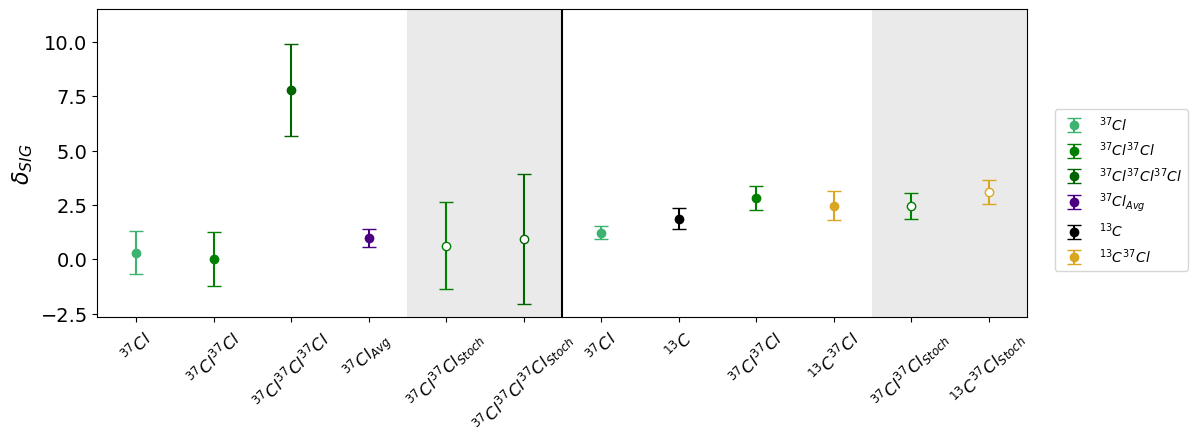

In [22]:
#different loop as these don't have IRMS
smp = 'WP'

#AGI
#textPositions = [4.0] * 4
#ylims = (0,5.2)
#LGC
textPositions = [8.0] * 4
ylims = (-5,11)

##FIGURE 3: Variant for WP 
###1: UNPACK DICTIONARY
#316 Frag
Cl = data[smp]['316']['37Cl']['Value']
ClErr = data[smp]['316']['37Cl']['Error']
ClDoub = data[smp]['316']['37Cl37Cl']['Value']
ClDoubErr = data[smp]['316']['37Cl37Cl']['Error']
ClTrip = data[smp]['316']['37Cl37Cl37Cl']['Value'] 
ClTripErr = data[smp]['316']['37Cl37Cl37Cl']['Error'] 
#235 Frag
aromaticDelta = data[smp]['235']['37Cl']['Value']
aromaticDeltaErr = data[smp]['235']['37Cl']['Error']
single13 = data[smp]['235']['13C']['Value']
single13Err = data[smp]['235']['13C']['Error']
C13Cl = data[smp]['235']['37Cl13C']['Value']
C13ClErr = data[smp]['235']['37Cl13C']['Error']
ClCl = data[smp]['235']['37Cl37Cl']['Value']
ClClErr = data[smp]['235']['37Cl37Cl']['Error']

#Convert from VPDB reference frame to vs SIG standard (-28.0 +/- 0.1)
C13EA = 1000*(op.deltaToRatio('13C', C13EAPDB) / op.deltaToRatio('13C', -28.0) - 1)
C13EAErr = np.sqrt(2) * 0.1

###2: Get estimates for single 37Cl in 316 fragment based on 3737 and 373737. Get weighted average. ###
###
###
#Compute single 37Cl enrichment for the 316 fragment data 
ClviaDoub, ClviaDoubErr = multipleEnrichmentToSingle(ClDoub, ClDoubErr, 2)
ClviaTrip, ClviaTripErr = multipleEnrichmentToSingle(ClTrip, ClTripErr, 3)

print(f'{ClviaDoub:.2f} +/- {ClviaDoubErr:.2f}')
print(f'{ClviaTrip:.2f} +/- {ClviaTripErr:.2f}')

#Get weighted errors 
wCl = 1/ClErr**2
wClDoub = 1/ClviaDoubErr**2
wClTrip = 1/ClviaTripErr**2

weights = [wCl, wClDoub, wClTrip]
values = [Cl, ClviaDoub, ClviaTrip]

#Calculate the weighted 37Cl value for the 316 fragment based on multiple observations 
Clwav = np.dot(weights, values) / np.sum(weights)
ClwavErr = np.sqrt(1 / np.sum(weights))

print("316 Cl WAV")
print(f'{Clwav:.2f} +/- {ClwavErr:.2f}')

###3 get predicted values for various clumps based on the individual subs
###
###
def deltaToAlpha(x):
    return x/1000+1
def alphaToDelta(x):
    return 1000*(x-1)

ClClPred = alphaToDelta(deltaToAlpha(aromaticDelta)**2)
ClClPredErr = 2 * aromaticDeltaErr
C13ClPred = alphaToDelta(deltaToAlpha(aromaticDelta) * deltaToAlpha(single13))
C13ClPredErr = np.sqrt(aromaticDeltaErr**2 + single13Err**2)
C13ClClPred = alphaToDelta(deltaToAlpha(aromaticDelta)**2 * deltaToAlpha(single13))
#Multiply by 2 prior to adding in quad
C13ClClPredErr = np.sqrt((2*aromaticDeltaErr)**2 + single13Err**2)

ClDoubPred = alphaToDelta(deltaToAlpha(Cl)**2)
ClDoubPredErr = 2 * ClErr
ClTripPred = alphaToDelta(deltaToAlpha(Cl)**3)
ClTripPredErr = 3 * ClErr


print("PREDICTIONS: 316")
print("37Cl37Cl")
print(f'{ClDoubPred:.2f}')
print(f'{ClDoubPredErr:.2f}')
print("37CL37Cl37Cl")
print(f'{ClTripPred:.2f}')
print(f'{ClTripPredErr:.2f}')

print("PREDICTIONS 235")
print("37Cl37Cl")
print(f'{ClClPred:.2f}')
print(f'{ClClPredErr:.2f}')
print("13C37Cl")
print(f'{C13ClPred:.2f}')
print(f'{C13ClPredErr:.2f}')
print("13C37Cl37Cl")
print(f'{C13ClClPred:.2f}')
print(f'{C13ClClPredErr:.2f}')

###4 PLOT
ids = ['Cl','ClCl','ClClCl','Cl_{Avg}','Cl','13C','ClCl','13CCl']
vals = [Cl, ClDoub, ClTrip, Clwav, aromaticDelta, single13, ClCl, C13Cl]
errs = [ClErr, ClDoubErr, ClTripErr, ClwavErr, aromaticDeltaErr, single13Err, ClClErr, C13ClErr]
colors = ['mediumseagreen','green','darkgreen','indigo','mediumseagreen','k','green','goldenrod']

preds = True
predids = ['ClCl_{Stoch}','ClClCl_{Stoch}','ClCl_{Stoch}','13CCl_{Stoch}']
predvals = [ClDoubPred, ClTripPred, ClClPred, C13ClPred]
prederrs = [ClDoubPredErr, ClTripPredErr, ClClPredErr, C13ClPredErr]
predcolors = ['green', 'darkgreen', 'green','goldenrod']


def reformat_string(s):
    s = s.replace('Cl', '^{37}Cl').replace('13C', '^{13}C')
    return f'${s}$'

# Apply the function to each element in the list
fullIds = ids[:4] + predids[:2] + ids[4:] + predids[2:]
niceFullIds = [reformat_string(item) for item in fullIds]

niceIds = [reformat_string(item) for item in ids]

fig, ax = plt.subplots(figsize = (12,4))

for idx, val in enumerate(vals):
    thisErr = errs[idx]
    thisC = colors[idx]
    thisId = niceIds[idx]
    thisX = idx if idx <= 3 else idx + 2

    ax.errorbar(thisX, val, yerr=thisErr, fmt = 'o', c = thisC, label = thisId, capsize = 5)

if preds:
    for idx, val in enumerate(predvals):
        thisErr = prederrs[idx]
        thisC = predcolors[idx]
        thisX = idx + 4 if idx <= 1 else idx + 8

        ax.errorbar(thisX, val, yerr=thisErr, fmt = 'o', mfc = 'w',
        mec = thisC, ecolor = thisC, capsize = 5)

#ax.set_ylim(ylims[0], ylims[1])
ymin, ymax = ax.get_ylim()
ymax = 11.5
#eps can't output transparency. This is what I got from 'gray' and alpha of 0.17. 
grey_color = (234/255, 234/255, 234/255)
ax.fill_between([3.5,5.5], ymin, ymax, facecolor=grey_color, hatch='')
ax.fill_between([9.5,11.5], ymin, ymax, facecolor=grey_color, hatch='')
#ax.set_ylim(ymin, ymax)
#ax.text(1,textPositions[0],'$316$', fontsize = 16)
#ax.text(4,textPositions[1],'$316_{Pred}$', fontsize = 16)
#ax.text(6.8,textPositions[2],'$235$', fontsize = 16)
#ax.text(9.65,textPositions[3],'$235_{Pred}$', fontsize = 16)

ax.vlines(5.5, ymin, ymax, color = 'k')
ax.set_xticks(range(len(niceFullIds)))
ax.set_xticklabels(niceFullIds, fontsize = 12, rotation = 45)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor = [1.18,0.7])
#ax.set_title("$" + smp + " vs SIG$")
ax.set_xlim(-0.5,11.5)
ax.set_ylim(ymin, ymax)

ax.set_ylabel("$\delta_{SIG}$", fontsize = 16)

fig.savefig(smp + 'vs SIG.eps', format="eps",transparent=True, bbox_inches = 'tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


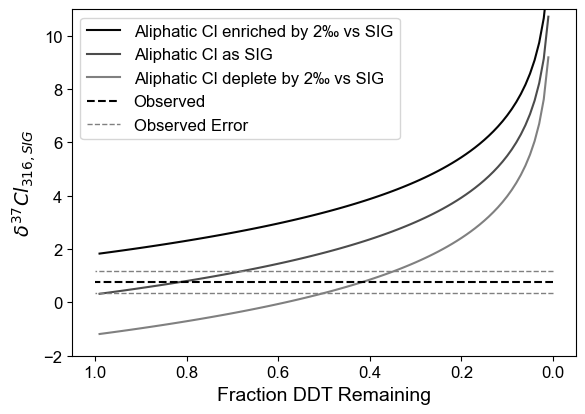

In [35]:
#Change 'n_ali_316' to 2 or 3 to try different cases. 

plt.rcParams.update({
    'font.family': 'Arial',           # Set global font
    'font.size': 14,                  # Base font size
    'axes.titlesize': 14,             # Title of the axes
    'axes.labelsize': 14,             # Axis labels
    'xtick.labelsize': 12,            # X tick labels
    'ytick.labelsize': 12,            # Y tick labels
    'legend.fontsize': 12,            # Legend font
    'figure.titlesize': 14,           # Figure title
})


import matplotlib.cm as cm
# Get the grays colormap
grays = cm.get_cmap('gray')

#manually change n_ali_316 to 2 for all cases
simParams = {'Aliphatic Cl enriched by 2‰ vs SIG':{'n_ali_316':3, 'deltaAliSmoc_MCC':-4},
			 'Aliphatic Cl as SIG':{'n_ali_316':3, 'deltaAliSmoc_MCC':-6},
			 'Aliphatic Cl deplete by 2‰ vs SIG':{'n_ali_316':3, 'deltaAliSmoc_MCC':-8},
			 #'Ali as standard_3':{'n_ali_316':3, 'deltaAliSmoc_MCC':-6},
			 #'Ali Deplete 2 per mil_3':{'n_ali_316':3, 'deltaAliSmoc_MCC':-8},
			 }

fig, ax = plt.subplots(figsize = (6.5,4.5))
thisC = ['tab:blue','k','tab:orange'] * 2
thisC = [grays(0.02),grays(0.3),grays(0.5)]
thisStyle = ['-','-','-','--']

for simIdx, (simKey, thisParams) in enumerate(simParams.items()):
	n_ali_316 = thisParams['n_ali_316']
	a_316 = (1000 - (3 * (n_ali_316 / 4)))/1000

	deltaAliSmoc_SIG = -6
	deltaAroSmoc_SIG = -2 

	deltaAliSmoc_MCC = thisParams['deltaAliSmoc_MCC']
	deltaAroSmoc_MCC = -0.8

	concAli_SIG = op.deltaToConcentration('Cl', deltaAliSmoc_SIG)
	concAro_SIG = op.deltaToConcentration('Cl', deltaAroSmoc_SIG)
	conc316_SIG = n_ali_316 * np.array(concAli_SIG) + (4-n_ali_316) * np.array(concAro_SIG)
	R316_SIG = conc316_SIG[2] / conc316_SIG[0]
	delta316_SIG = op.ratioToDelta('Cl', conc316_SIG[2] / conc316_SIG[0])

	concAli_MCC = op.deltaToConcentration('Cl', deltaAliSmoc_MCC)
	concAro_MCC = op.deltaToConcentration('Cl', deltaAroSmoc_MCC)
	conc316_MCC = n_ali_316 * np.array(concAli_MCC) + (4-n_ali_316) * np.array(concAro_MCC)
	delta316_MCC = op.ratioToDelta('Cl', conc316_MCC[2] / conc316_MCC[0])

	R0 = conc316_MCC[2] / conc316_MCC[0]
	
	#thisL = [r'$\alpha = 0.998$',r'$\alpha$ = 0.996',r'$\alpha = 0.990$']
	deltas_SMOC = []
	deltas_SIG = []
	fs = np.arange(0.01,1,0.01)
	for f in fs:
		R = R0 * f**(a_316-1)
		delta_SMOC = op.ratioToDelta('Cl',R)
		deltas_SMOC.append(delta_SMOC)

		delta_SIG = 1000* (R / R316_SIG - 1)
		deltas_SIG.append(delta_SIG)

	ax.plot(fs, deltas_SIG, c = thisC[simIdx], linestyle = thisStyle[simIdx], label = simKey)
	
grey_color = (128/255, 128/255, 128/255)
ax.hlines(0.76,0,1, color = 'k', linestyle = '--', label = "Observed")
ax.hlines(0.76+0.42,0,1, color = grey_color, linestyle = '--', linewidth = 1,label = "Observed Error")
ax.hlines(0.76-0.42,0,1, color = grey_color, linestyle = '--', linewidth = 1)
ax.invert_xaxis()
ax.set_xlabel("Fraction DDT Remaining")
ax.set_ylabel("$\delta^{37}Cl_{316,SIG}$")
ax.legend()
ax.set_ylim(-2,11)
fig.savefig('Figure_4_Degradation.eps', format="eps", bbox_inches = 'tight')